# COGS 150 Final Project

SP25

Danny Rivera

A16906333

In [1]:
%pip install transformers

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from tqdm import tqdm
import transformers
from transformers import AutoTokenizer

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Introduction

For my final project, I thought it would be interesting to create a project similar to the work done in Lab 2, where we evaluated whether an LLM was sensitive to certain stimuli using minimal pairs, with conditions for both grammatical and agrammatical words. For my research question, I will be evaluating the following:

> Are LLMs sensitive to double-negatives?

I thought it would be interesting to study double-negatives specifically, since while they are technically grammatically incorrect, they are used often in informal language, and are a common feature in certain dialects.

Because of this, surprisal results could have different implications. High surprisal results for sentences with double-negatives could indicate that the model has learned this grammatical rule, and *is* sensitive to the stimuli. However, it could also mean that the model has not understood double-negatives as a commonly-used feature of English language, and that they are underrepresented in a model's training data. Likewise, low surprisal could indicate either that the model has not learned this grammatical rule, or that it recognizes it as a common form of speech. The ambiguity and implications of these potential results are what motivated me to study double-negatives in particular.

## Stimuli

### Description

I created 10 minimal pairs, which feature one grammatically correct sentence and one grammatically incorrect sentence featuring a double-negative clause, for a total of 20 items. These will be categorized under two separate conditions; `Grammatical` and `Agrammatical`.

For example, one minimal pair uses the sentence clause "I didn't see", where an expected, grammatically correct word could be "anyone", while the double-negative "no one" could be used here as well.

In [4]:
# list of 10 minimal pairs
stimuli = [
    ("I didn't see", " anyone", "Grammatical"),
    ("I didn't see", " no one", "Agrammatical"),
    ("You don't know", " anything", "Grammatical"),
    ("You don't know", " nothing", "Agrammatical"),
    ("We can't go", " anywhere", "Grammatical"),
    ("We can't go", " nowhere", "Agrammatical"),
    ("She doesn't want it", " anymore", "Grammatical"),
    ("She doesn't want it", " no more", "Agrammatical"),
    ("We didn't tell", " anybody", "Grammatical"),
    ("We didn't tell", " nobody", "Agrammatical"),
    ("It won't do you", " any good", "Grammatical"),
    ("It won't do you", " no good", "Agrammatical"),
    ("I haven't got", " any time", "Grammatical"),
    ("I haven't got", " no time", "Agrammatical"),
    ("He doesn't have", " any idea", "Grammatical"),
    ("He doesn't have", " no idea", "Agrammatical"),
    ("They haven't been of", " any help", "Grammatical"),
    ("They haven't been of", " no help", "Agrammatical"),
    ("I don't want", " any other", "Grammatical"),
    ("I don't want", " no other", "Agrammatical")
]

In [5]:
# create a DataFrame with each minimal pair, item, and condition
df_stimuli = pd.DataFrame(stimuli, columns = ['Sentence', 'Word', 'Condition'])

# limit to 6 rows for readability
df_stimuli.head(6)

,Sentence,Word,Condition
0,I didn't see,anyone,Grammatical
1,I didn't see,no one,Agrammatical
2,You don't know,anything,Grammatical
3,You don't know,nothing,Agrammatical
4,We can't go,anywhere,Grammatical
5,We can't go,nowhere,Agrammatical


### Discussion of limitations of stimuli

I created sentences that vary not only in the statement used, but that also vary in pronouns, verbs, and so on. I did this to try and ensure that my stimuli were representative of different types of commonly used words, since using repeated words could skew surprisal results. However, it is a well-known fact that humans aren't very good at randomization, or accounting for each possible factor, so it is very likely that my sentences still may be underrepresentative of common language. Also, LLMs have been known to encode gender biases, so using sentences with certain pronouns here like "she" or "he" may be involuntarily playing into gender stereotypes found in both human language and LLMs, and could lead to inaccurate results. Lastly, a total of 10 minimal pairs is an extremely small set of test stimuli, especially when comparing it to the large amount of data LLMs like GPT-2 are trained and evaluated on, so results could prove to be insignificant.

## Code

### Loading Tokenizer and Model

First, I will load the tokenizer and the model I will be evaluating, which is GPT-2. It is worth noting that GPT-2 may now be outdated compared to newer transformer models GPT-4, which use a much larger training dataset and have more parameters. Therefore, the type of model used here may be another limitation to this project.

In [6]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
gpt2 = transformers.AutoModelForCausalLM.from_pretrained('gpt2')
gpt2.eval() # evaluation mode rather than training

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### Creating a function to run through each minimal pair

I will now use a function to calculate probability for a certain word, which will then be used to run through each minimal pair and its two items, the grammatical and agrammatical words. The code for the function below was taken from Lab 2.

In [8]:
def next_seq_prob(model, tokenizer, seen, unseen):
  '''Get p(unseen | seen)

  Parameters
  ----------
  model : transformers.PreTrainedModel
      Model to use for predicting tokens
  tokenizer : transformers.PreTrainedTokenizer
      Tokenizer for Model
  seen : str
      Input sequence
  unseen: str
      The sequence for which to calculate a probability
  '''

  # get IDs for tokens
  input_ids = tokenizer.encode(seen, return_tensors='pt')
  unseen_ids = tokenizer.encode(unseen)

  # loop through unseen tokens, store log probs
  log_probs = []

  for unseen_id in unseen_ids:

    # run model on input
    with torch.no_grad():
      logits = model(input_ids).logits

    # get next token prediction logits
    next_token_logits = logits[0, -1]
    next_token_probs = torch.softmax(next_token_logits, 0) # normalize

    # get probability for relevant token in unseen string & store
    prob = next_token_probs[unseen_id]
    log_probs.append(torch.log(prob))

    # add input tokens incrementally to input
    input_ids = torch.cat((input_ids, torch.tensor([[unseen_id]])), 1)

  # add log probs together to get total log probability of sequence
  total_log_prob = sum(log_probs)

  # exponentiate to return to probabilities
  total_prob = torch.exp(total_log_prob)

  return total_prob.item()

### Obtaining surprisal for each minimal pair and item

After creating the function above, I will create a list `results` that will hold the results from each minimal pair that is analyzed through the model, including the word, its condition (either `Grammatical` for non-double-negatives or `Agrammatical` for double-negatives), its probability, and its surprisal. I will then format these results into a Pandas DataFrame, to allow for later visualization and analysis.

In [9]:
results = []
for index, row in tqdm(df_stimuli.iterrows(), total=df_stimuli.shape[0]):
  prob = next_seq_prob(gpt2, tokenizer, row['Sentence'], row['Word'])

  results.append({
      'Sentence' : row['Sentence'],
      'Word' : row['Word'],
      'Condition' : row['Condition'],
      'Probability' : prob,
      'Surprisal' : -np.log2(prob)
  })

# create DataFrame
df_results = pd.DataFrame(results)

# limit to 6 rows for readability
df_results.head(6)

100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


,Sentence,Word,Condition,Probability,Surprisal
0,I didn't see,anyone,Grammatical,0.025525,5.291970
1,I didn't see,no one,Agrammatical,0.000018,15.747697
2,You don't know,anything,Grammatical,0.019375,5.689694
3,You don't know,nothing,Agrammatical,0.000367,11.413838
4,We can't go,anywhere,Grammatical,0.016659,5.907538
5,We can't go,nowhere,Agrammatical,0.000294,11.733056


In [10]:
# verify that we have 10 minimal pairs & 20 items
print(f"Number of minimal pairs: {df_results['Sentence'].nunique()}")
print(f"Number of items: {df_results.shape[0]}")

Number of minimal pairs: 10
Number of items: 20


## Results

### Overall Results (Grammatical vs. Agrammatical)

After iterating through each minimal pair and storing its results, I can now observe overall surprisal values for each of the two conditions.

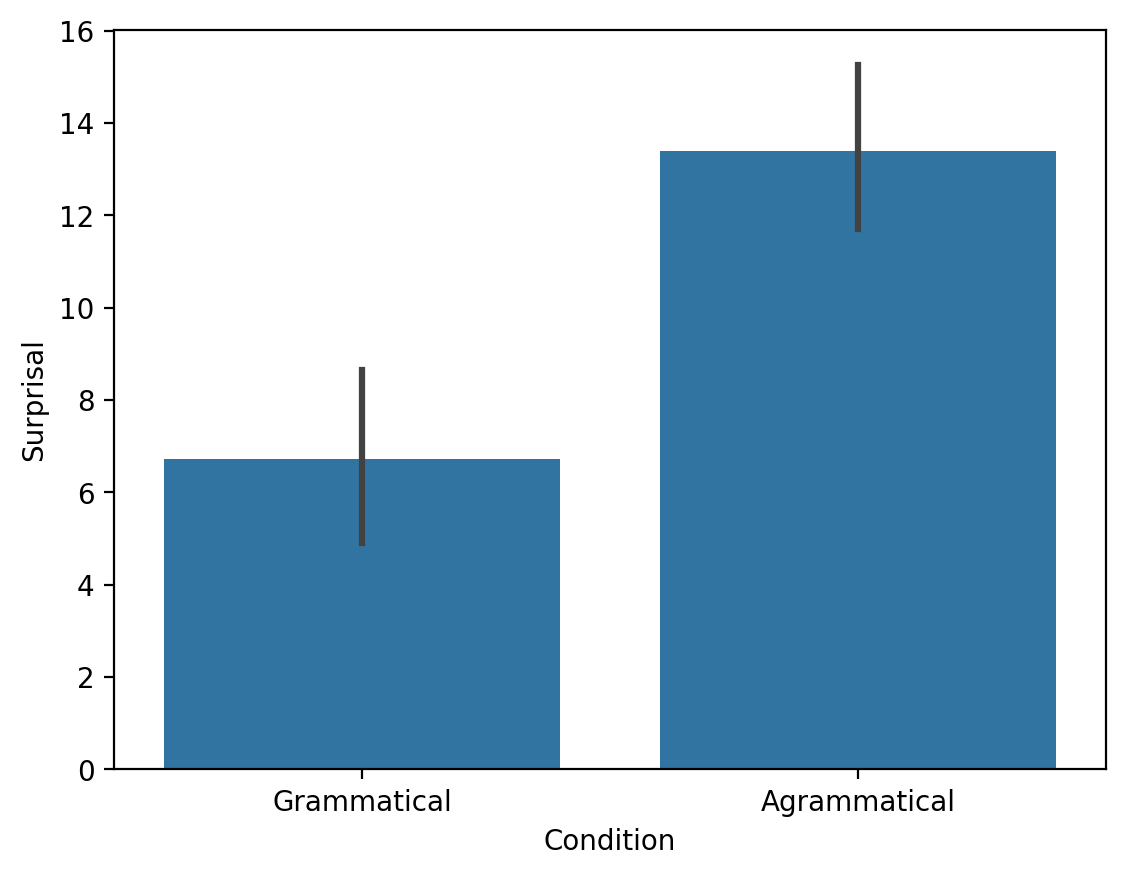

In [11]:
# visualize results
ax = sns.barplot(data=df_results, x='Condition', y='Surprisal')
plt.show()

### Example of individual results

#### Minimal Pair 1

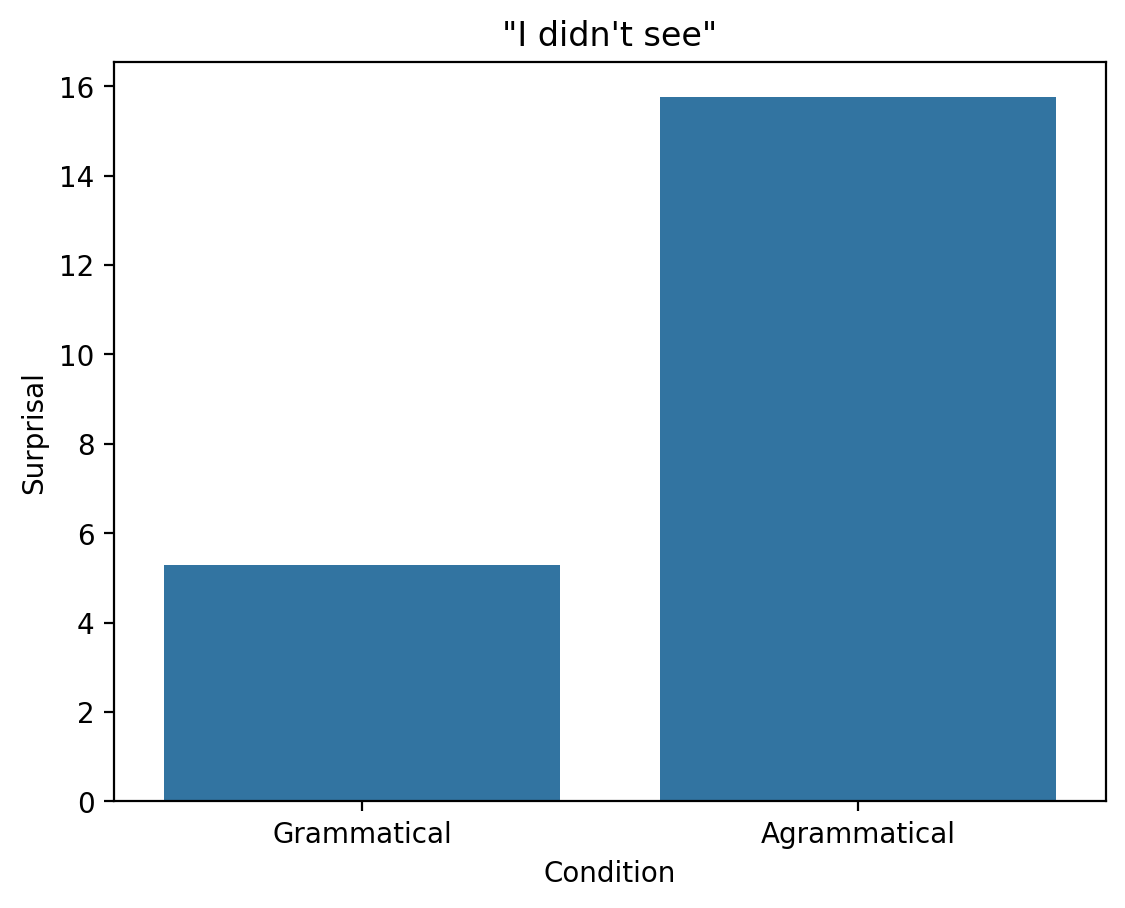

In [12]:
ax = sns.barplot(data=df_results.iloc[0:2], x='Condition', y='Surprisal')
plt.title(f'"{df_results["Sentence"].iloc[0]}"')
plt.show()

## Discussion

Overall, the results show high surprisal for the `Agrammatical` condition, where a double-negative was used for the corresponding sentence clause. Average surprisal for sentences with double-negatives was nearly twice as much as average surprisal for those without.

One limitation that is worth noting here is that using ambiguous stimuli means that we cannot be completely certain whether or not the model is sensitive to it. While it appears that the model is more surprised by double-negatives, or agrammatical stimuli, these are still often used, so it raises the question of whether or not the model is equally surprised by double-negatives as any other form of incorrect language. A good way to test this would be to add a third item that would not make any sense at all, and compare its surprisal to that of the double-negative item. For example, for the minimal pair "I didn't see anyone" vs. "I didn't see no one", a random third word such as "aren't" could be used to create the sentence "I didn't see aren't", which is completely incorrect and nonsensical, and compare surprisal values. If surprisal for the new, third item is roughly equal to that of the double-negative item, it could imply that the model does not understand or expect double-negatives at all. If surprisal for the third item is significantly higher than that of the double-negative item, it could mean that the model may expect and recognize double-negatives to a certain degree.

High surprisal for the agrammatical stimuli suggests that the model has learned this grammatical rule, where double-negatives should not be used. However, as discussed earlier, double-negatives, while grammatically incorrect, are used frequently in casual conversation and are found in certain dialects. Therefore, double-negatives are a complicated case when looking at English rules of grammar, and these results can have multiple implications.

High surprisal indicates that double-negatives are not found frequently in the model's training data. It would make sense for grammatically incorrect sentences to be missing or sparsely found in a model's training data. However, this does not mean that double-negatives are rarely used by English speakers. Since they are often used in informal situations or within communities that speak certain dialects, it could imply biases in the data, where there is underrepresentation for informal dialogue or language spoken by certain communities. This aligns with the limitations of GPT models discussed in class, including that their training data has been primarily in English, written rather than spoken, and online. This may also align with a phenomenon discussed in the Atari et al. (2023) paper, which found that GPT-4 appears to be trained primarily on "WEIRD" data, and underrepresents language from marginalized communities.

LLMs that contain biases in their training data can have significant consequences, as they may end up perpetuating those same biases when deployed. Double-negatives are often used in African-American Vernacular English (AAVE), but it may be that the model evaluated here (GPT-2) understands double-negatives as a grammatically incorrect feature only, with no nuance. Therefore, it may be that dialogue from AAVE speakers, whom are primarily Black Americans, are underrepresented in the model's data. By containing biased data underrepresenting this group, a feedback loop is created where GPT-2 and other models may erase dialogue from these speakers, and could even amplify harmful stereotypes against them that already exist.

As LLMs grow in use, these issues can go from mere data limitations to ones that affect real-world decisions and reinforce harmful biases. LLMs that perpetuate human biases against certain groups can create psychological harm to people of those groups when using the model or being exposed to its outputs. Furthermore, a LLM that generates incorrect and harmful text about certain groups may be used by malicious people intending to further spread stereotypes and propaganda against those groups. Also, LLMs may be used for decision making that can negatively impact the groups that it shows biases against.

For these reasons, a simple grammar evaluation test on a model can actually be a sign of a larger issue, where data is underrepresentative of real-world diversity in language, and can strengthen harmful biases found in humans. Because of this, it is important to test models for their accuracy and representation, as well as fine-tune them to ensure that they are used to benefit humanity rather than make its issues worse.